In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


filename = 'top_500.csv'
file = f'../data/01_raw/{filename}'

try:
    data = pd.read_csv(file)
    print(f"Plik '{file}' został poprawnie wczytany.")
except Exception as e:
    print(f"Błąd podczas wczytywania pliku: {e}")
    data = pd.DataFrame()

Plik '../data/01_raw/top_500.csv' został poprawnie wczytany.


In [20]:
# Podstawowe informacje o danych
info = pd.DataFrame({
    'Typ kolumny': data.dtypes,
    'Brakujące wartości': data.isnull().sum(),
    'Unikalne wartości': data.nunique()
})

print(f"Rozmiar danych: {data.shape[0]} wierszy × {data.shape[1]} kolumn\n")
display(info)

Rozmiar danych: 498 wierszy × 47 kolumn



,Typ kolumny,Brakujące wartości,Unikalne wartości
appid,int64,0,498
name,object,0,465
release_date,object,0,427
required_age,int64,0,6
price,float64,0,42
dlc_count,int64,0,51
detailed_description,object,32,433
about_the_game,object,32,433
short_description,object,29,436
reviews,object,312,167


Kolumny z wartościami numerycznymi:
['appid', 'required_age', 'price', 'dlc_count', 'metacritic_score', 'achievements', 'recommendations', 'user_score', 'score_rank', 'positive', 'negative', 'average_playtime_forever', 'average_playtime_2weeks', 'median_playtime_forever', 'median_playtime_2weeks', 'discount', 'peak_ccu', 'pct_pos_total', 'num_reviews_total', 'pct_pos_recent', 'num_reviews_recent']


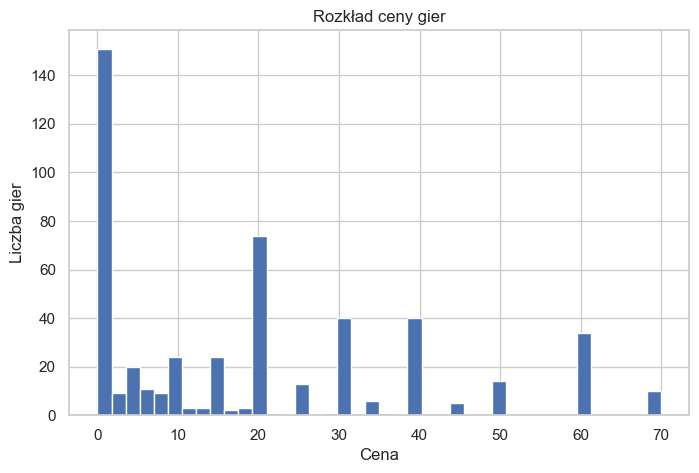

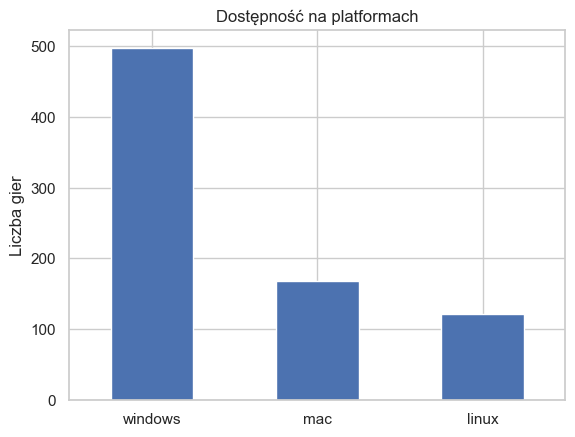

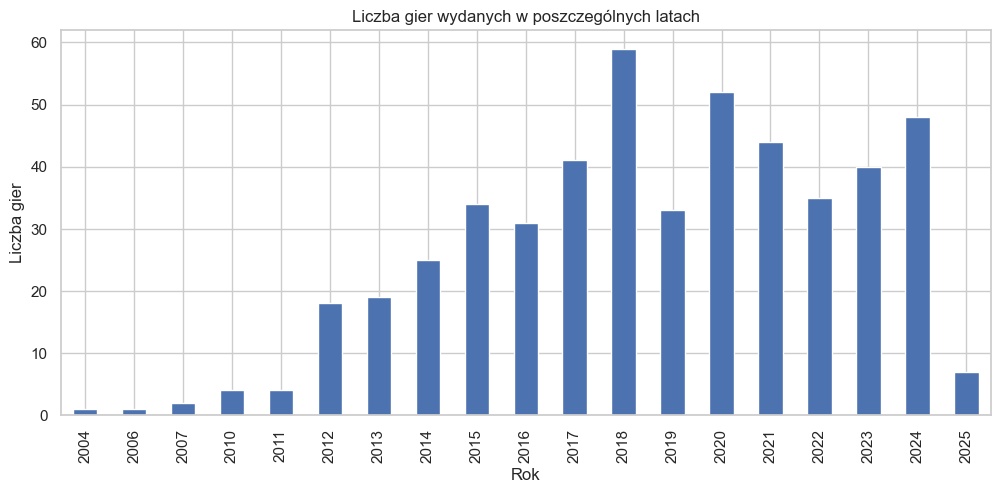

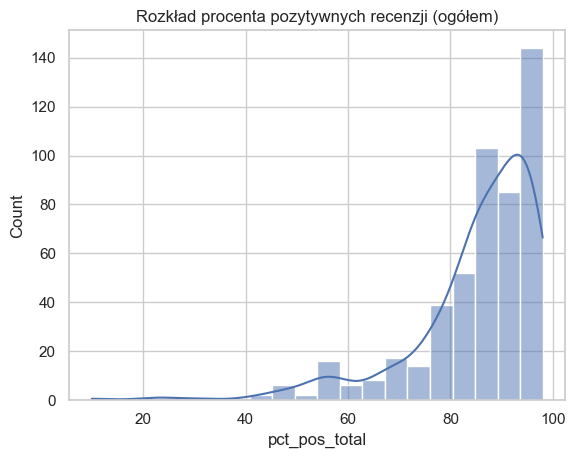

In [21]:
# Rozkład cech numerycznych
sns.set_theme(style="whitegrid")

# Kolumny z wartościami numerycznymi
all_num_cols = data.select_dtypes(include=['int64', 'float64']).columns
print("Kolumny z wartościami numerycznymi:")
print(list(all_num_cols))

# Histogram ceny
data["price"].plot(kind="hist", bins=40, title="Rozkład ceny gier", figsize=(8, 5))
plt.xlabel("Cena")
plt.ylabel("Liczba gier")
plt.show()

# Liczba gier na poszczególne platformy
data[["windows", "mac", "linux"]].sum().plot(kind="bar", title="Dostępność na platformach", rot=0)
plt.ylabel("Liczba gier")
plt.show()

# Liczba gier w poszczególnych latach
pd.to_datetime(data["release_date"], errors="coerce").dt.year.value_counts().sort_index().plot(kind="bar",
                                                                                               figsize=(12, 5))
plt.title("Liczba gier wydanych w poszczególnych latach")
plt.xlabel("Rok")
plt.ylabel("Liczba gier")
plt.show()

# Rozkład pozytywnych recenzji
sns.histplot(data['pct_pos_total'], bins=20, kde=True)
plt.title("Rozkład procenta pozytywnych recenzji (ogółem)")
plt.show()

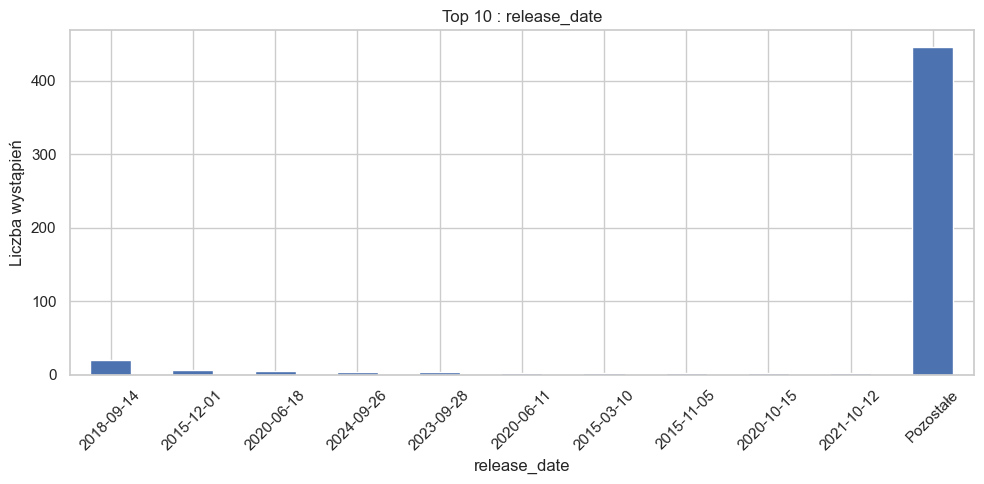

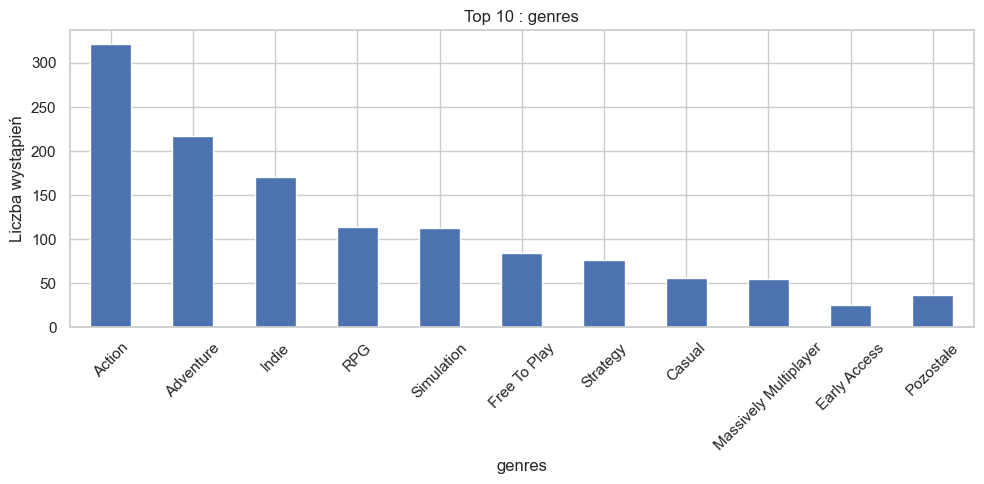

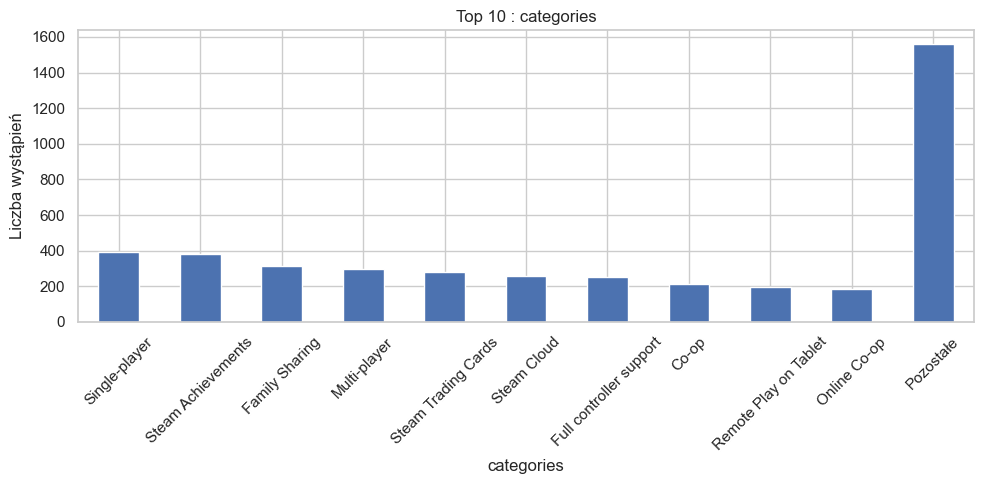

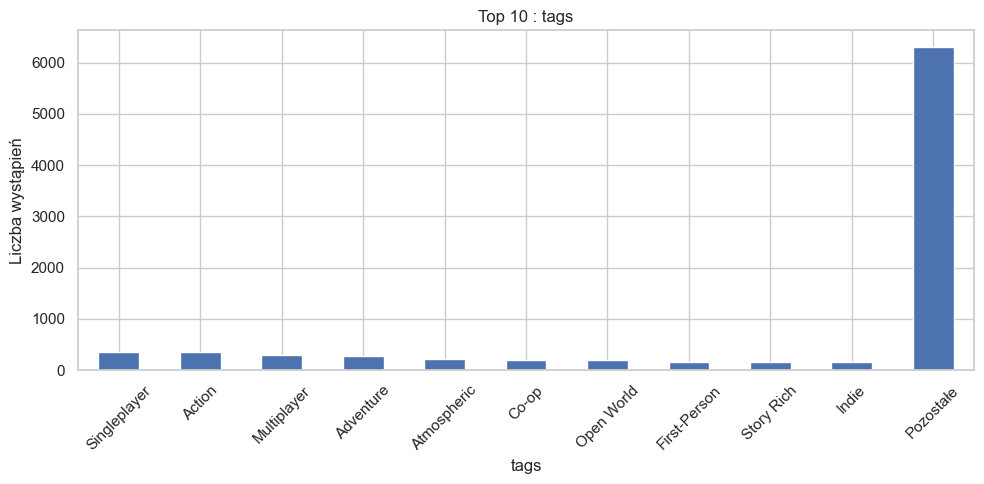

In [22]:
# Rozkład cech kategorycznych 

# kolumny kategoryczne sensowne do analizy 
cat_cols = ['release_date', 'genres', 'categories', 'tags']

for col in cat_cols:
    if col not in data.columns:
        continue  # pomijam kolumny, których nie ma w danych

    # kolumny typu lista do rozbicia i zliczenia
    # niektore kolumny mają zapis w typie string z listą, np. "['Action', 'Adventure']" przez to że gra mieści się np w wielu genrach
    if col in ['genres', 'categories', 'tags', 'platforms', 'steamspy_tags']:
        exploded = data[col].dropna().apply(lambda x: eval(x) if isinstance(x, str) else x).explode()
        counts = exploded.value_counts()
    else:
        # zwykłe kolumny w typie stringa
        counts = data[col].value_counts()

    # kategorie zliczane które warto przedstawić w zestawieniu Najczęściej występujących
    if len(counts) > 10:
        top_counts = counts[:10]
        top_counts['Pozostałe'] = counts[10:].sum()
        plot_data = top_counts
        title = f"Top 10 : {col}"
    else:
        plot_data = counts
        title = f"Rozkład kategorii dla {col}"

    plt.figure(figsize=(10, 5))
    plot_data.plot(kind='bar')
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel('Liczba wystąpień')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [23]:
#Wstępna Agregacja danych i określenie targetu

#usnięcie kolumn gdzie jest wiecej niż 30% pustych wierszy
threshold = 0.3
for col in data.columns:
    missing_ratio = data[col].isnull().mean()
    if missing_ratio > threshold:
        print(col.title() + "dropped")
        data.drop(columns=col, inplace=True)

#usuniecie kolumn positive i negative -> zapobieganie data leak
if 'positive' and 'negative' in data.columns:
    data.drop(columns=['positive', 'negative'], inplace=True)
    print("columns=[ 'positive', 'negative'] dropped")

#enkodowanie danych kategorycznych

#data wydania -> rok, miesiac wydania.
if 'release_date' in data.columns:
    data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')
    data['release_year'] = data['release_date'].dt.year
    data['release_month'] = data['release_date'].dt.month
    data.drop(columns=['release_date'], inplace=True)
    print("encoded relase_date to datetime -> year, month")

# dane kategoryczne na binarne -> int 0-1
columns_to_process = ['website', 'support_url', 'detailed_description', 'about_the_game', 'short_description',
                      'header_image', 'screenshots', 'movies']
for col in columns_to_process:
    if col in data.columns:
        data["has_" + col] = data[col].notnull().astype(int)
        data.drop(columns=[col], inplace=True)
        print("object to bin : " + col)

# systemy operacyjne -> bool na int 0-1
columns_to_process = ['windows', 'mac', 'linux']

for col in columns_to_process:
    if col in data.columns:
        data[col] = data[col].fillna(False).astype(int)
        print(f"converted bool {col}")

# usunięcie niepotrzebnych kolumn
columns_to_process = [
    'num_reviews_recent',
    'pct_pos_recent',  # bardzo szybko są outdated wiec usuwamy.

]
for col in columns_to_process:
    if col in data.columns:
        data.drop(columns=[col], inplace=True)
        print("object dropped : " + col)

#todo zastanowić się jak to obrobić.
#11  supported_languages       498 non-null    object
#12  full_audio_languages      498 non-null    object
#13  packages                  498 non-null    object
#14  developers                498 non-null    object
#15  publishers                498 non-null    object
#16  categories                498 non-null    object
#17  genres                    498 non-null    object
#18  estimated_owners

#% pozytywnych ocen -> nasz target - > 'pct_pos_total'

Reviewsdropped
Support_Emaildropped
Metacritic_Urldropped
Notesdropped
Score_Rankdropped
columns=[ 'positive', 'negative'] dropped
encoded relase_date to datetime -> year, month
object to bin : website
object to bin : support_url
object to bin : detailed_description
object to bin : about_the_game
object to bin : short_description
object to bin : header_image
object to bin : screenshots
object to bin : movies
object dropped : num_reviews_recent
object dropped : pct_pos_recent


In [24]:
#  PODSUMOWANIE I EKSPORT DANYCH

print(" Podsumowanie po czyszczeniu")
data.info()

# zapis do pliku CSV
output_path = f"../data/02_interim/Cleaned_{filename}"
data.to_csv(output_path, index=False, encoding='utf-8')

print(f"\n Dane edytowane i zapisane do pliku: {output_path}")


 Podsumowanie po czyszczeniu
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appid                     498 non-null    int64  
 1   name                      498 non-null    object 
 2   required_age              498 non-null    int64  
 3   price                     498 non-null    float64
 4   dlc_count                 498 non-null    int64  
 5   windows                   498 non-null    bool   
 6   mac                       498 non-null    bool   
 7   linux                     498 non-null    bool   
 8   metacritic_score          498 non-null    int64  
 9   achievements              498 non-null    int64  
 10  recommendations           498 non-null    int64  
 11  supported_languages       498 non-null    object 
 12  full_audio_languages      498 non-null    object 
 13  packages                  498 non-nu